In [1]:
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import numpy as np
from scipy import special as spec

In [2]:
def Qfunc(x):
    return 0.5-0.5*spec.erf(x/np.sqrt(2))

def theoryBER(M, EbN0, constType):
    
    EbN0lin = 10**(EbN0/10)        
    k  = np.log2(M) 
    
    if constType == 'qam':
        L  = np.sqrt(M)      
        Pb = 2*(1-1/L)/np.log2(L)*Qfunc(np.sqrt(3*np.log2(L)/(L**2-1)*(2*EbN0lin)))
        
    elif constType == 'psk':
        Ps = 2*Qfunc(np.sqrt(2*k*EbN0lin)*np.sin(np.pi/M))
        Pb = Ps/k
    
    return Pb  

def CDcompensation(Ex, Ey, Ltotal, D, Fc, Fs):
    
    c = 299792458   # speed of light (vacuum)
    c_kms = c/1e3
    λ = c/Fc
    β2 = -(D*λ**2)/(2*np.pi*c_kms)
    γ = gamma
    
    l = len(Ex)
    
    Nfft = l;

    ω = 2*np.pi*Fs*fftfreq(Nfft)    
   
    Ex = fft(Ex) #Pol. X 
    Ey = fft(Ey) #Pol. Y 
    
    # CD compensation
    Ex = Ex*np.exp(-1j*(β2/2)*(ω**2)*(Ltotal))
    Ey = Ey*np.exp(-1j*(β2/2)*(ω**2)*(Ltotal))
    
    Ex = ifft(Ex)
    Ey = ifft(Ey)
      
    return Ex, Ey


def manakovSSF(Ex, Ey, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fs):
    
    c = 299792458   # speed of light (vacuum)
    c_kms = c/1e3
    λ  = c/Fc
    α  = alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c_kms)
    γ  = gamma
            
    Nfft = len(Ex)

    ω = 2*np.pi*Fs*fftfreq(Nfft)
    
    Nspans = int(np.floor(Ltotal/Lspan))
    Nsteps = int(np.floor(Lspan/hz))

    Ex = fft(Ex) #Pol. X 
    Ey = fft(Ey) #Pol. Y 
    
    for spanN in range(1, Nspans+1):
        for stepN in range(1, Nsteps+1):
            
            # First linear step (frequency domain)
            Ex = Ex*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
            Ey = Ey*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))

            # Nonlinear step (time domain)
            Ex = ifft(Ex);
            Ey = ifft(Ey);
            
            Ex = Ex*np.exp(1j*γ*8/9*(np.abs(Ex)**2 + np.abs(Ey)**2)*hz)
            Ey = Ey*np.exp(1j*γ*8/9*(np.abs(Ex)**2 + np.abs(Ey)**2)*hz)
   
            # Second linear step (frequency domain)
            Ex = fft(Ex);
            Ey = fft(Ey);
            Ex = Ex*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
            Ey = Ey*np.exp(-α*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
        
        Ex = Ex*np.exp(α*Nsteps*hz)
        Ey = Ey*np.exp(α*Nsteps*hz)
    
    Ex = ifft(Ex)
    Ey = ifft(Ey)
    
    return Ex, Ey
    

In [3]:
Ltotal = 100
Lspan  = 10
hz = 0.1
alpha = 0.2
gamma = 1.3
D = 16
Fc = 193.1e12
Fs = 64e9
P0 = 1e-3

In [4]:
from scipy import signal
import matplotlib.pyplot as plt
t       = np.linspace(-4, 4, 128, endpoint=False)
i, q, e = signal.gausspulse(t, fc=5, retquad=True, retenv=True)

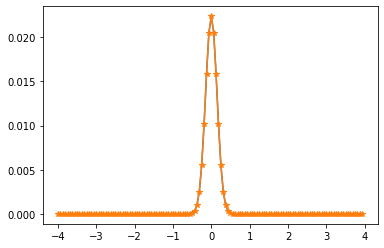

In [5]:
Ex = np.sqrt(P0/2)*e
Ey = np.sqrt(P0/2)*e

plt.plot(t, np.abs(Ex), t, np.abs(Ey),'*-')

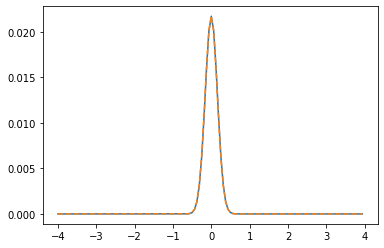

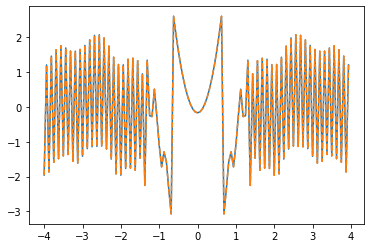

In [6]:
Ex_out, Ey_out = manakovSSF(Ex, Ey, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fs)

plt.plot(t, np.abs(Ex_out), t, np.abs(Ey_out),'--')
plt.figure()
plt.plot(t, np.angle(Ex_out), t, np.angle(Ey_out),'--')

In [7]:
from commpy.modulation import Modem, QAMModem
from commpy.utilities  import signal_power, upsample
from commpy.filters    import rrcosfilter
from scipy.signal import lfilter

In [8]:
def filterNoDelay(h, x):
    """
    h: impulse response (symmetric)
    x: input signal 
    y: output signal
    """   
    N = h.size
    x = np.pad(x, (0, int(N/2)),'constant')
    y = lfilter(h,1,x)
    
    return y[int(N/2):y.size]

In [44]:

Ltotal = 800
Lspan  = 50
hz = 1
alpha = 0.2
gamma = 1.3
D = 4
Fc = 193.1e12
Fs = 64e9
P0 = 4e-3

# simulation parameters

M   = 16  # Modulation order
SpS = 8

Rs     = 32e9
Ts     = 1/Rs         # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)   # Frequência de amostragem do sinal (amostras/segundo)
alpha  = 1            # Rolloff do filtro RRC
N      = 4*1024       # Número de coeficientes do filtro RRC
EbN0dB = 20
   
# generate random bits
np.random.seed(33)
bits_x   = np.random.randint(2, size=3*2**14)    
np.random.seed(23)
bits_y   = np.random.randint(2, size=3*2**14)    

# map bits to constellation symbols
mod = QAMModem(m=M)
symb_x = mod.modulate(bits_x)
symb_y = mod.modulate(bits_y)

Es = mod.Es;

# normalize symbols energy to 1
symb_x = symb_x/np.sqrt(Es)
symb_y = symb_y/np.sqrt(Es)

# upsampling
symbolsUp_x = upsample(symb_x, SpS)
symbolsUp_y = upsample(symb_y, SpS)

# pulse shaping
tindex, rrcFilter = rrcosfilter(N, alpha, Ts, Fa)
sig_x  = filterNoDelay(rrcFilter, symbolsUp_x)     
sig_y  = filterNoDelay(rrcFilter, symbolsUp_y)

sig_x  = np.sqrt(P0/2)*sig_x/np.sqrt(signal_power(sig_x))
sig_y  = np.sqrt(P0/2)*sig_y/np.sqrt(signal_power(sig_y))


sig_x_out, sig_y_out = manakovSSF(sig_x, sig_y, hz, Lspan, Ltotal, alpha, gamma, D, Fc, Fa)
sig_x_out, sig_y_out = CDcompensation(sig_x_out, sig_y_out, Ltotal, D, Fc, Fa)

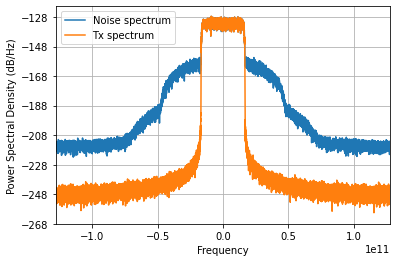

In [10]:
# plot spectrums
plt.figure(2);
plt.psd(sig_x_out,Fs=Fa, NFFT = 16*1024, label = 'Noise spectrum')
plt.psd(sig_x,Fs=Fa, NFFT = 16*1024, label = 'Tx spectrum')
plt.legend(loc='upper left');
plt.xlim(-Fa/2,Fa/2);

EbN0: 20.00 dB, EbN0_est: 28.38 dB,
BERtheory: 0.0e+00, BER: 0.0e+00 
Total of bits counted:  48752


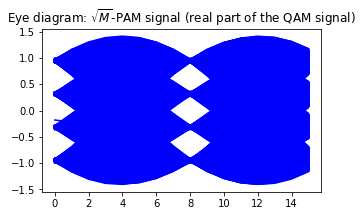

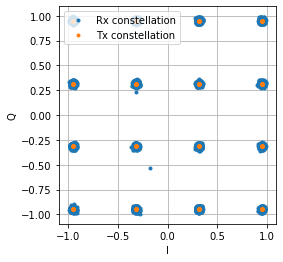

In [59]:
sigRx = sig_x_out
symbTx = symb_x
bitsTx = bits_x

sigRx = sigRx/np.sqrt(signal_power(sigRx))

# matched filter
sigRx = filterNoDelay(rrcFilter, sigRx)    
sigRx = sigRx/SpS

# downsampling to one sample per symbol
symbRx = sigRx[0::SpS]

rot = np.mean(symbTx/symbRx)
symbRx = rot*symbRx
sigRx  = rot*sigRx

# plot eye diagrams
plt.figure(3,figsize=(5,3))
plt.title('Eye diagram: $\sqrt{M}$-PAM signal (real part of the QAM signal)')
plt.plot(np.transpose(sigRx.real.reshape(int(sigRx.size/(2*SpS)),2*SpS)),color='blue');

# demodulate received symbols        
bitsRx = mod.demodulate(np.sqrt(Es)*symbRx, demod_type = 'hard') 

# BER calculation
discard = 200
numBits = bitsTx.size

ERR = np.logical_xor(bitsRx[discard:numBits-discard], bitsTx[discard:numBits-discard])
BER = ERR.sum()/ERR.size

# EbN0 estimation
EbN0dB_est = 10*np.log10(1/(signal_power(symbRx-symbTx)*np.log2(M)))

BERtheory = theoryBER(M, EbN0dB,'qam')

# print results
print('EbN0: %3.2f dB, EbN0_est: %3.2f dB,\nBERtheory: %3.1e, BER: %3.1e ' %(EbN0dB, EbN0dB_est, BERtheory, BER))   
print('Total of bits counted: ', ERR.size)

# plot constellations
plt.figure(4)
plt.plot(symbRx.real,symbRx.imag,'.', label ='Rx constellation');
plt.plot(symbTx.real,symbTx.imag,'.', label ='Tx constellation')
plt.legend(loc='upper left');
plt.xlabel('I');
plt.ylabel('Q');
plt.grid()
plt.axis('square');

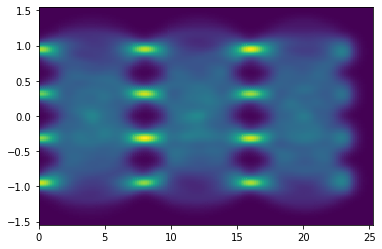

In [60]:
from scipy.stats.kde import gaussian_kde

y = (sigRx[0:30000]).real
x = np.arange(0,y.size,1) % 24

k = gaussian_kde(np.vstack([x, y]))
k.set_bandwidth(bw_method=k.factor/2)

xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1);

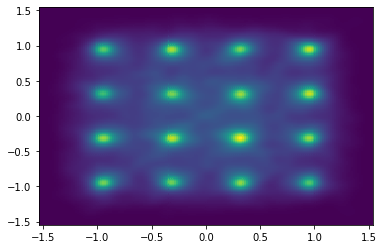

In [72]:
y = (sigRx[0:30000]).real
x = (sigRx[0:30000]).imag

k = gaussian_kde(np.vstack([x, y]))
k.set_bandwidth(bw_method=k.factor/2)

xi, yi = 1.1*np.mgrid[x.min():x.max():x.size**0.5*1j,y.min():y.max():y.size**0.5*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1);

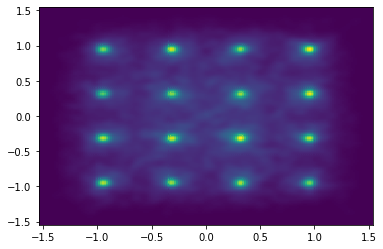

In [68]:
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=1);